In [1]:
# all the packages you need
from __future__ import division
import sys
import numpy as np
import time
import scipy.io as io
import scipy.sparse as sparse
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# synthetic data generator
# n is number of samples, d is number of dimensions, k is number of nonzeros in w, sigma is std of noise, 
# X is a n x d data matrix, y=Xw+w_0+noise is a n-dimensional vector, w is the true weight vector, w0 is true intercept
def DataGenerator(n = 50, d = 75, k = 5, sigma = 1.0, w0 = 0.0, seed = 256):
    
    np.random.seed(seed)
    X = np.random.normal(0,1,(n,d))
    w = np.random.binomial(1,0.5,k)
    noise = np.random.normal(0,sigma,n)
    w[w == 1] = 10.0
    w[w == 0] = -10.0
    w = np.append(w, np.zeros(d - k))
    y = X.dot(w) + w0 + noise
    return (X, y, w, w0)

In [3]:
# initialization of W for lasso by least square regression or ridge regression
def Initialw(X, y):

    n, d = X.shape
    # increment X
    if sparse.issparse(X):
        XI = sparse.hstack((X, np.ones(n).reshape(n,1)))
    else:
        XI = np.hstack((X, np.ones(n).reshape(n,1)))

    if sparse.issparse(X):
        if n >= d:
            w = sparse.linalg.lsqr(XI, y)[0]
        else:
            w = sparse.linalg.inv(XI.T.dot(XI) + 1e-3 * sparse.eye(d+1)).dot(XI.T.dot(y))
            w = w.T
    else:
        if n >= d:
            w = np.linalg.lstsq(XI, y)[0]
        else:
            w = np.linalg.inv(XI.T.dot(XI) + 1e-3 * np.eye(d+1)).dot(XI.T.dot(y))
 
    return (w[:d], w[d])

In [4]:
# Helper and example function of sparse matrix operation for Problem 2.5
# W: a scipy.sparse.csc_matrix
# x: a vector with length equal to the number of columns of W
# In place change the data stored in W,
# so that every row of W gets element-wise multiplied by x
def cscMatInplaceEleMultEveryRow(W, x):
    indptr = W.indptr
    last_idx = indptr[0]
    for col_id, idx in enumerate(indptr[1:]):
        if idx == last_idx:
            continue
        else:
            W.data[last_idx:idx] *= x[col_id]
            last_idx = idx

In [72]:
# Problem 2.1
# TODO: coordinate descent of lasso, note lmda stands for lambda
def lasso(X, y, lmda = 10.0, epsilon = 1.0e-2, max_iter = 100, draw_curve = False):
    # Initialize the weights using provided function    
    w, w0 = Initialw(X, y)

    n, m = X.shape
    #print(n, m, y.shape, w.shape, w0.shape)
    
    # Initialize our iteratior, max change, and objective function
    iter = 0
    F = (1/2) * np.sum(X @ w + w0 - y) + lmda * np.sum(np.absolute(w))

    while True:
        # Update iterator for given loop and reset our max_change
        iter += 1
        max_change = 0

        for k in range(m):
            # Solve for r_k
            r_k = y - np.delete(X, [k], axis=1) @ np.delete(w, [k])

            # Solve for a_k and c_k
            X_k = X[:, k]
            a_k = 2 * np.sum(X_k**2)
            c_k = 2 * np.sum(np.multiply(r_k, X_k))
            #print(a_k, c_k)

            # Calculate new w_k, cross-compare new weight to old weight to determine if max_change needs to be updated (for break condition), then save w_k at w[k]
            w_k = np.sign(c_k) * np.maximum(0, np.absolute(c_k) - lmda) / a_k
            if np.absolute(w_k - w[k]) > max_change:
                max_change = np.absolute(w_k - w[k])

            w[k] = w_k
            #print(w_k)
        
        # Calculate our new objective value F
        F_new = (1/2) * np.sum(X @ w + w0 - y) + lmda * np.sum(np.absolute(w))
        F = np.append(F, F_new)

        # After updating our weights, check against exit conditions: (1) number of steps will not exceed max_iter and (2) no element in w changes more than epsilon between successive iterations
        if iter > 100 or max_change <= epsilon:
            break

    # If draw_curve set to true, draw a plot of objective value with respect to coordinate descent step
    if draw_curve == True:
        fig, ax = plt.subplots(figsize=(10, 8))
        plt.plot(F, ls = '-', marker = 'o', label = '')
        plt.grid()
        plt.xlabel('Iteration')
        plt.ylabel('$Objective Value - F$')
        plt.title('Objective value $F$ as a function of coordinate descent step using lasso regression')
        fig.show()
        plt.savefig('Problem_3_a.png')

    return (w,w0)

In [73]:
# Problem 2.1: data generation
X, y, w_true, w0_true = DataGenerator(n=50, d=75, k=5, sigma=1.0)
# have a look at generated data and true model
print(X)
print(y)
print(w_true)
print(w0_true)

[[ 0.10430293 -0.55011253 -0.07271465 ...  0.9858945   0.9762621
   0.66088793]
 [-1.00421694 -0.98028568  1.04231343 ...  0.54423528 -0.12555319
   0.29833038]
 [-0.93920808 -0.88460697 -0.36846914 ...  1.13839265 -0.17706563
  -1.1040073 ]
 ...
 [ 0.22627269 -1.41473902 -1.38744153 ...  0.40629811  1.81803336
   0.57718998]
 [-0.87827944 -1.1588945  -0.20821426 ...  2.5616317   0.71706683
  -1.6834583 ]
 [ 1.18136184  0.97753967 -1.08284432 ... -0.26515022  1.70874717
   1.25566562]]
[ -2.94661658  -9.2469922   -6.61852337  -8.71813976  -2.77082316
 -21.16384608   2.47720978  -8.18425969  17.12490003  13.69805685
  27.11926075 -35.71631086 -11.85971212  18.6242186  -10.34229026
 -26.02528015 -38.1950294   19.8767635    0.46858206  -3.92985654
   8.35960867  22.22456719 -63.25244103  -7.14048583   8.24525032
  23.62138731 -28.79749873  -3.8576642   18.13970725  43.72678802
 -24.73981649  -8.27834954  40.86565523  32.20353774  -7.46417913
  -1.43551809 -33.9853813   15.26040273   9.931

[ 9.87701348 -9.72978372 -9.78533191  9.85809008 10.08126976  0.
 -0.          0.04990917 -0.         -0.         -0.         -0.02029786
  0.22101146 -0.          0.10649288 -0.          0.12528557  0.
 -0.         -0.          0.          0.01886022  0.01337888  0.01044934
  0.         -0.02632922 -0.          0.         -0.          0.
 -0.         -0.          0.          0.          0.08118375  0.
 -0.06709603 -0.         -0.         -0.          0.          0.
  0.          0.          0.          0.         -0.          0.
  0.04079482 -0.          0.         -0.          0.25100621 -0.
 -0.01947527 -0.          0.          0.         -0.          0.
 -0.         -0.03668451  0.         -0.13301942  0.          0.
 -0.          0.          0.          0.         -0.         -0.05597532
 -0.          0.          0.        ]


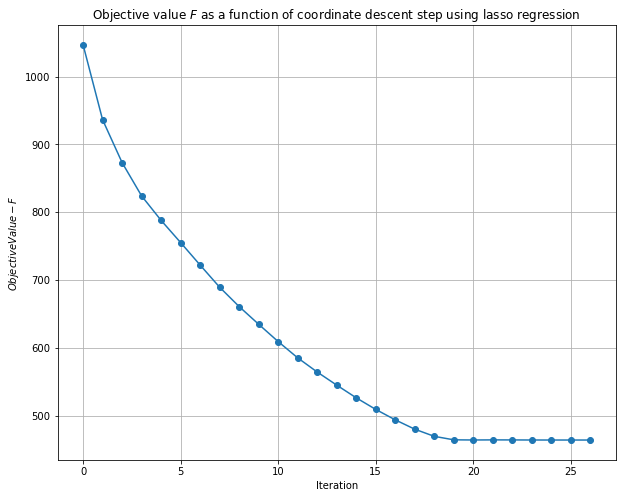

In [74]:
# Problem 2.1: run lasso and plot the convergence curve
# TODO: run lasso for one synthetic data
w_lasso, w0_lasso = lasso(X, y, lmda = 10.0, epsilon = 1.0e-2, draw_curve = True, max_iter = 100)
# have a look at the lasso model you got (sparse? where?)
print(w_lasso)

In [93]:
# Problem 2.2
def pred_fn(X, theta, theta_0):
    pred = X @ theta + theta_0
    return pred

def root_mean_square_error(pred, y):
    rmse = np.sqrt(np.sum((pred - y)**2) / np.size(y))
    return rmse

def Evaluate(X, y, w, w0, w_true, w0_true):
    # First calculate the precision and recall - find the indices of each non-zero term in both w and w_true. Find the intersection of these two arrays of non-zero indices. Compute the precision and recall given equations (6) and (7).
    w_nonzero = np.nonzero(w)
    w_true_nonzero = np.nonzero(w_true)

    precision_w = np.size(np.intersect1d(w_nonzero, w_true_nonzero)) / np.size(w_nonzero) 
    recall_w = np.size(np.intersect1d(w_nonzero, w_true_nonzero)) / np.size(w_true_nonzero)

    # Calculate RMSE using equation (5) from homework 2
    rmse = root_mean_square_error(pred_fn(X, w, w0), y)

    # Calculate sparsity
    sparsity_w = np.size(w_nonzero)

    return (rmse, sparsity_w, precision_w, recall_w)

In [94]:
# Problem 2.2
# TODO: apply your evaluation function to compute precision (of w), recall (of w), sparsity (of w) and training RMSE
Emetric = Evaluate(X, y, w_lasso, w0_lasso, w_true, w0_true)
print(Emetric)

(1.7920605964601177, 22, 0.22727272727272727, 1.0)


In [ ]:
# Problem 2.3
# TODO: compute a lasso solution path, draw the path(s) in a 2D plot
def LassoPath(X, y):
    #########TODO##########
    return (W, W0, Lmda)

In [ ]:
# Problem 2.3
# TODO: evaluate a given lasso solution path, draw plot of precision/recall vs. lambda
def EvaluatePath(X, y, W, W0, w_true, w0_true, Lmda):
    #########TODO##########
    return (RMSE, Sparsity, Precision, Recall)

In [ ]:
# Problem 2.3
# TODO: draw lasso solution path and precision/recall vs. lambda curves
X, y, w_true, w0_true = DataGenerator(n=50, d=75, k=5, sigma=1.0)

In [ ]:
# Problem 2.3
# TODO: try a larger std sigma = 10.0
X, y, w_true, w0_true = DataGenerator(n=50, d=75, k=5, sigma=10.0)

In [ ]:
# Problem 2.4
# TODO: try another 5 different choices of (n,d) 
# draw lasso solution path and precision/recall vs. lambda curves, use them to estimate the lasso sample complexity
X, y, w_true, w0_true = DataGenerator(n=50, d=150, k=5, sigma=1.0)

In [ ]:
# Problem 2.5: predict reviews' star on Yelp
# data parser reading yelp data
def DataParser(Xfile, yfile, nfile, train_size = 4000, valid_size = 1000):

    # read X, y, feature names from file
    fName = open(nfile).read().splitlines()
    y = np.loadtxt(yfile, dtype=np.int)
    if Xfile.find('mtx') >= 0:
        # sparse data
        X = io.mmread(Xfile).tocsc()
    else:
        # dense data
        X = np.genfromtxt(Xfile, delimiter=",")

    # split training, validation and test set
    X_train = X[0 : train_size,:]
    y_train = y[0 : train_size]
    X_valid = X[train_size : train_size + valid_size,:]
    y_valid = y[train_size : train_size + valid_size]
    X_test = X[train_size + valid_size : np.size(X,0),:]
    y_test = y[train_size + valid_size : np.size(y,0)]

    return (X_train, y_train, X_valid, y_valid, X_test, y_test, fName)

In [ ]:
# Problem 2.5: predict reviews' star on Yelp
# TODO: evaluation funtion that computes the lasso path, evaluates the result, and draws the required plots
def Validation(X_train, y_train, X_valid, y_valid):
    #########TODO##########
    return (w_lasso, w0_lasso, lmda_best)

In [ ]:
# Problem 2.5: predict reviews' star on Yelp
# TODO: evaluation of your results

# load Yelp data: change the address of data files on your own machine if necessary ('../data/' in the below)
from scipy.sparse.linalg import lsqr
X_train, y_train, X_valid, y_valid, X_test, y_test, fName = DataParser('../data/star_data.mtx', '../data/star_labels.txt', '../data/star_features.txt', 30000, 5000)

# evaluation
w_lasso, w0_lasso, lmda_best = Validation(X_train, y_train, X_valid, y_valid)

# print the top-10 features you found by lasso
idx = (-np.abs(w_lasso)).argsort()[0:10]
print('Lasso select features:')
for i in range(10):
    print(fName[idx[i]],w_lasso[idx[i]])